In [1]:
from tqdm.auto import tqdm
import torch

TORCH_COMPILE_DEBUG=1
torch.cuda.empty_cache()

In [2]:
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import Compose, ToTensor, Resize, Lambda


# define image transformations (e.g. using torchvision)
transform = Compose([
    Resize(28*2),
    #RandomHorizontalFlip(),
    ToTensor(),
    Lambda(lambda t: (t * 2) - 1)
])

reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2),
    transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
    transforms.ToPILImage(),
])

dataset = datasets.MNIST(
    root="../../data/datasets",
    train=True,
    download=False,
    transform=transform,
    
)
channels, image_size, _ = dataset[0][0].shape
batch_size = 128

dataset = Subset(dataset, indices=torch.arange(0, len(dataset)//6))

print(f'taille dataset: {len(dataset)}')

# create dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

taille dataset: 10000


In [3]:
from torch.optim import Adam
from models.unet.TemporalUNet import TemporalUNet
from models.diffusion.DDPM import DDPM


device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

model = TemporalUNet(
    in_channels=1,
    out_channels=1,
    channel_scale=image_size,
    channels_mult=(2, 2, 4)
)
"""
model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)"""

optimizer = Adam(model.parameters(), lr=1e-3)

diffusion_model = DDPM(denoiser=model, timestep=300, schedule_type='cosine')

### Training

In [4]:
epochs = 6
losses = []

for epoch in range(epochs):
    training_batches_progress = tqdm(range(len(dataloader)),
                                 desc='Epoch {}/{}'.format(epoch + 1, epochs))
    losses.append(0.0)
    
    for images in dataloader:
        images, _ = images
        images = images.to(device)
    
        optimizer.zero_grad()
        loss = diffusion_model.compute_loss(images)
        loss.backward()
        optimizer.step()
    
        losses[-1] += len(images) * loss.item()
        
        training_batches_progress.update()
    losses[-1] /= len(dataset)
    
    training_batches_progress.set_postfix_str(str(f'Loss: {losses[-1]:.4f}'))
    training_batches_progress.close()

Epoch 1/6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/6:   0%|          | 0/79 [00:00<?, ?it/s]

### Forward process

In [5]:
from utils.visualization import plot_forward_diffusion

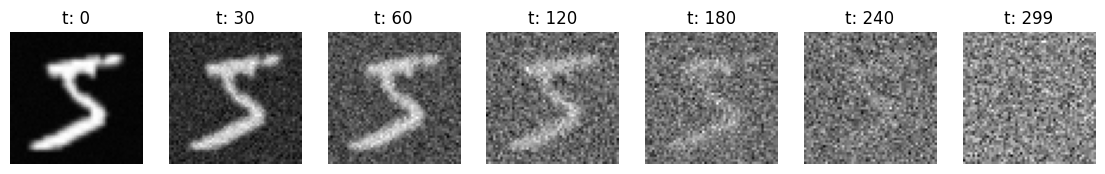

In [6]:
T = diffusion_model.timestep
x_noisy = plot_forward_diffusion(
    diffusion_model, 
    dataset[0][0].to(device), 
    sequence_t=list(map(int, [0, 0.1*T, 0.2*T, 0.4*T, 0.6*T, 0.8*T, T-1]))
)

### Reconstruction

In [7]:
rec_sec_image = diffusion_model.rec_reverse_sampling(x_noisy)

reverse process: 300it [00:02, 103.73it/s]


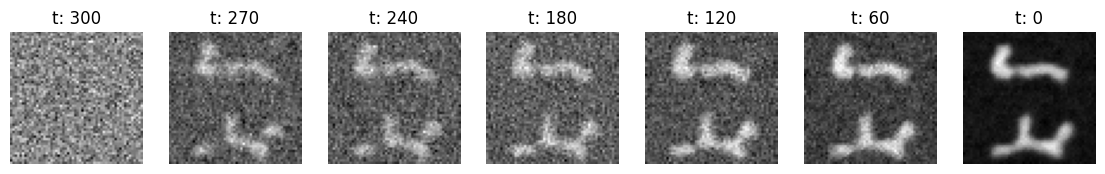

In [8]:
from utils.visualization import plot_reverse_diffusion
T = diffusion_model.timestep
plot_reverse_diffusion(
    rec_sec_image,
    sequence_t=list(map(int, [0, 0.1*T, 0.2*T, 0.4*T, 0.6*T, 0.8*T, T])), 
    diffusion_step=diffusion_model.timestep)

In [9]:
rec_sec_image[diffusion_model.timestep-1]

array([[[[-0.4898751 , -0.5542264 , -0.636933  , ..., -0.6136406 ,
          -0.69056255, -0.66569746],
         [-0.5699368 , -0.79013836, -0.6566747 , ..., -0.64602506,
          -0.73539317, -0.6422412 ],
         [-0.6155896 , -0.67345184, -0.7343512 , ..., -0.5934865 ,
          -0.63796514, -0.5951984 ],
         ...,
         [-0.6663512 , -0.70693684, -0.5643883 , ..., -0.65083265,
          -0.57273954, -0.7005201 ],
         [-0.6497456 , -0.5649045 , -0.6837981 , ..., -0.6428964 ,
          -0.60465133, -0.64281344],
         [-0.67191935, -0.53804404, -0.6878626 , ..., -0.7079433 ,
          -0.64807975, -0.7655059 ]]]], dtype=float32)

In [10]:
print(f'\mu: {rec_sec_image[diffusion_model.timestep-1].mean():.4f}')
print(f'\sigma: {rec_sec_image[diffusion_model.timestep-1].std():.4f}')

\mu: -0.4965
\sigma: 0.3016


### Generation

In [12]:
image_shape = torch.Size([1, channels, image_size, image_size])
batch_gen_images = diffusion_model.generate_reverse_sampling(image_shape)

reverse process: 300it [00:03, 98.96it/s] 


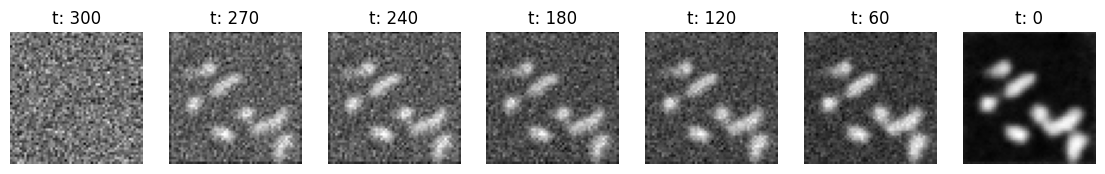

In [13]:
plot_reverse_diffusion(
    batch_gen_images, 
    sequence_t=list(map(int, [0, 0.1*T, 0.2*T, 0.4*T, 0.6*T, 0.8*T, T])), 
    diffusion_step=diffusion_model.timestep
)

# Architecture

In [14]:
from models.unet.TemporalUNet import TemporalUNet

model = TemporalUNet(1,1, 56, channels_mult=(1,2,4))

from torchinfo import summary

summary_kwargs = dict(col_names=['input_size', 'output_size', 'kernel_size', 'num_params'], depth=3, verbose=0)

summary(model, [(128, 1, 56, 56), (128,)], **summary_kwargs)

Layer (type:depth-idx)                                       Input Shape               Output Shape              Kernel Shape              Param #
TemporalUNet                                                 [128, 1, 56, 56]          [128, 1, 56, 56]          --                        --
├─Sequential: 1-1                                            [128]                     [128, 224]                --                        --
│    └─SinusoidalPositionEmbeddings: 2-1                     [128]                     [128, 56]                 --                        --
│    └─Linear: 2-2                                           [128, 56]                 [128, 224]                --                        12,768
│    └─GELU: 2-3                                             [128, 224]                [128, 224]                --                        --
│    └─Linear: 2-4                                           [128, 224]                [128, 224]                --                        